Stochastic Volatilty Models
#### Seminar 4
---

# Black-Scholes in practice

In [1]:
from typing import Union, Optional, Callable
from dataclasses import dataclass
import numpy as np
import numpy.typing as npt
from scipy import stats  
from scipy import optimize
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
from copy import deepcopy

from ipywidgets import interact
from ipywidgets import widgets

DARK_THEME = True

if DARK_THEME:
    plt.style.use("dark_background")
    mpl.rcParams["figure.facecolor"] = "none"
    mpl.rcParams["axes.facecolor"] = "none"

In [2]:
FloatArray = npt.NDArray[np.float_]
Floats = Union[float, FloatArray]

In [3]:
@dataclass
class MarketState:
    stock_price: Floats
    interest_rate: Floats
    time: Floats = 0

@dataclass
class StockOption:
    strike_price: Floats
    expiration_time: Floats  # in years
    is_call: Union[bool, npt.NDArray[np.bool_]]
    
    def payoff(self, stock_price: Floats) -> Floats:
        call_payoff = np.maximum(0, stock_price - self.strike_price)
        put_payoff = np.maximum(0, self.strike_price - stock_price)
        return np.where(self.is_call, call_payoff, put_payoff)

@dataclass
class CallStockOption(StockOption):
    def __init__(self, strike_price, expiration_time):
        super().__init__(strike_price, expiration_time, True)
        
@dataclass
class PutStockOption(StockOption):
    def __init__(self, strike_price, expiration_time):
        super().__init__(strike_price, expiration_time, False)    

@dataclass
class BSParams:
    volatility: Floats

## The formulas

In [4]:
def dt(option: StockOption, ms: MarketState):
    return np.maximum(option.expiration_time - ms.time, np.finfo(np.float64).eps)


def d1(option: StockOption, ms: MarketState, params: BSParams):
    return 1 / (params.volatility * np.sqrt(dt(option, ms)))\
                * (np.log(ms.stock_price / option.strike_price)
                   + (ms.interest_rate + params.volatility ** 2 / 2) * dt(option, ms))


def d2(option: StockOption, ms: MarketState, params: BSParams):
    return d1(option, ms, params) - params.volatility * np.sqrt(dt(option, ms))

In [5]:
def price(option: StockOption, ms: MarketState, params: BSParams):
    discount_factor = np.exp(-ms.interest_rate * (dt(option, ms)))
    
    call_price = stats.norm.cdf(d1(option, ms, params)) * ms.stock_price\
            - stats.norm.cdf(d2(option, ms, params)) * option.strike_price * discount_factor
    put_price = stats.norm.cdf(-d2(option, ms, params)) * option.strike_price * discount_factor\
        - stats.norm.cdf(-d1(option, ms, params)) * ms.stock_price
    
    return np.where(option.is_call, call_price, put_price)

In [7]:
def delta(option: StockOption, ms: MarketState, params: BSParams):
    nd1 = stats.norm.cdf(d1(option, ms, params))
    return np.where(option.is_call, nd1, nd1 - 1)


def gamma(option: StockOption, ms: MarketState, params: BSParams):
    return stats.norm.pdf(d1(option, ms, params)) / (ms.stock_price * params.volatility * np.sqrt(dt(option, ms)))


def theta(option: StockOption, ms: MarketState, params: BSParams):
    a = -ms.stock_price * stats.norm.pdf(d1(option, ms, params)) * params.volatility\
        / (2 * np.sqrt(dt(option, ms)))
    d_discount_factor = ms.interest_rate * np.exp(-ms.interest_rate * (dt(option, ms)))

    call_theta = a - option.strike_price * d_discount_factor * stats.norm.cdf(d2(option, ms, params))
    put_theta = a + option.strike_price * d_discount_factor * stats.norm.cdf(-d2(option, ms, params))
    return np.where(option.is_call, call_theta, put_theta)


def vega(option: StockOption, ms: MarketState, params: BSParams):
    return ms.stock_price * stats.norm.pdf(d1(option, ms, params)) * np.sqrt(dt(option, ms))


def rho(option: StockOption, ms: MarketState, params: BSParams):
    discount_factor = np.exp(-ms.interest_rate * (dt(option, ms)))
    call_rho = option.strike_price * dt(option, ms) * discount_factor * stats.norm.cdf(d2(option, ms, params))
    put_rho = -option.strike_price * dt(option, ms) * discount_factor * stats.norm.cdf(-d2(option, ms, params))
    return np.where(option.is_call, call_rho, put_rho)

In [8]:
strikes = np.linspace(50, 150, 5)
times = np.linspace(0, 2, 4)

calls = CallStockOption(strike_price=strikes,
                        expiration_time=times[:, None])
puts = PutStockOption(strike_price=strikes,
                      expiration_time=times[:, None])

ms = MarketState(stock_price=100, interest_rate=0.1)

params = BSParams(volatility=0.167)

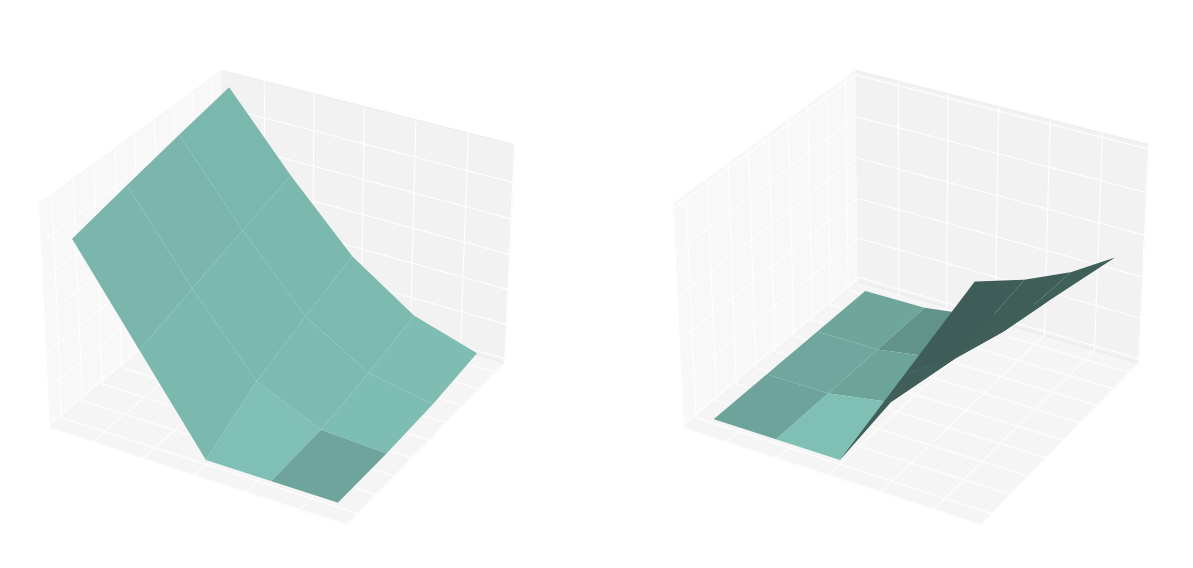

In [9]:
x, y = np.meshgrid(strikes, times)
call_price = price(calls, ms, params)
put_price = price(puts, ms, params)

fig = plt.figure(figsize=(15, 8))

ax1 = fig.add_subplot(121, projection='3d')
ax1.plot_surface(x, y, call_price)
ax1.set_title('Call option price')
ax1.set_xlabel('Strike price, $')
ax1.set_ylabel('Time to expiration, years')
ax1.set_zlabel('Option price, $')

ax2 = fig.add_subplot(122, projection='3d')
ax2.plot_surface(x, y, put_price)
ax2.set_title('Put option price')
ax2.set_xlabel('Strike price, $')
ax2.set_ylabel('Time to expiration, years')
ax2.set_zlabel('Option price, $')

plt.show()

In [11]:
def plot_all(type_: str = 'Call',
             time_to_expiration: float = 0.25,
             volatility: float = 0.1587,
             stock_price: float = 100.0,
             interest_rate: float = 0.0):
    opt = StockOption(strike_price=np.linspace(20, 200, 100),
                      expiration_time=time_to_expiration,
                      is_call=(type_ == 'Call'))
    ms = MarketState(stock_price=stock_price,
                        interest_rate=interest_rate)
    params = BSParams(volatility=volatility)
    
    data = {
        'price': price(opt, ms, params),
        'delta': delta(opt, ms, params),
        'gamma': gamma(opt, ms, params),
        'vega': vega(opt, ms, params),
        'theta': theta(opt, ms, params),
        'rho': rho(opt, ms, params)
    }

    fig, axs = plt.subplots(2, 3, figsize=(20, 10))

    for name, ax in zip(data, axs.flatten()):
        ax.plot(opt.strike_price, data[name])
        ax.set_title(name)
        ax.set_xlabel('Strike price')
        
    plt.show()

In [12]:
interact(plot_all,
         type_=widgets.Dropdown(options=['Call', 'Put'], value='Call', description='Option type'),
         time_to_expiration=widgets.FloatSlider(min=0.01, max=5.0, step=0.01, value=0.25, description='Time to expiration, years'),
         volatility=widgets.FloatSlider(min=0.1, max=2.0, step=0.01, value=0.1587, description='Volatility, annualized'),
         stock_price=widgets.FloatSlider(min=50.0, max=150.0, value=100.0, description='Stock price'),
         interest_rate=widgets.FloatSlider(min=0, max=0.2, step=0.005, value=0.0, description='Interest rate, annualized'));

interactive(children=(Dropdown(description='Option type', options=('Call', 'Put'), value='Call'), FloatSlider(…

# 

## IV 

In [13]:
def fit_params(option: CallStockOption, ms: MarketState, option_price: float) -> BSParams:
    
    RTOL = 1e-6
    VOL_MIN = 0.0
    VOL_MAX = 10.0
    MAX_ITER = 100
    
    s = deepcopy(ms)
    vol = 0.2

    lb = VOL_MIN
    rb = VOL_MAX
    
    for i in range(MAX_ITER):
        
        params = BSParams(vol)
        p = price(option, s, params)
        resid = p - option_price
        if abs(resid) / option_price < RTOL:
            break
        
        # try Newton step if vega is not zero
        v = vega(option, s, params)
        if v > 0 and not np.isclose(v, 0):
            new_vol = vol - (p - option_price) / v
        else:
            new_vol = np.nan

        # if something went wrong, bisect
        if np.isnan(new_vol) or new_vol < lb or new_vol > rb:
            new_vol = (lb + rb) / 2

        params = BSParams(new_vol)
        new_p = price(option, s, params)

        if new_p > option_price:
            rb = new_vol
        else:
            lb = new_vol
        
        vol = new_vol
        p = new_p
        
    return params

In [14]:
df = pd.read_csv("calls.csv")
df

,strike,price,yahoo_iv,stock_price,time_to_expiration
0,150.0,288.73,0.8307,430.78,0.83
1,160.0,278.77,0.7858,430.78,0.83
2,190.0,242.60,0.5232,430.78,0.83
3,200.0,232.63,0.4950,430.78,0.83
4,250.0,183.87,0.4016,430.78,0.83
...,...,...,...,...,...
86,550.0,1.34,0.1594,430.78,0.83
87,560.0,1.02,0.1601,430.78,0.83
88,565.0,0.89,0.1605,430.78,0.83
89,600.0,0.42,0.1681,430.78,0.83


In [15]:
market_state = MarketState(stock_price=df.at[0, "stock_price"], interest_rate=0.0)
for idx, row in df.iterrows():
    option = CallStockOption(strike_price=row["strike"],
                             expiration_time=row["time_to_expiration"])
    df.at[idx, "iv"] = fit_params(option, market_state, row["price"]).volatility

Mean squared error: 0.00004


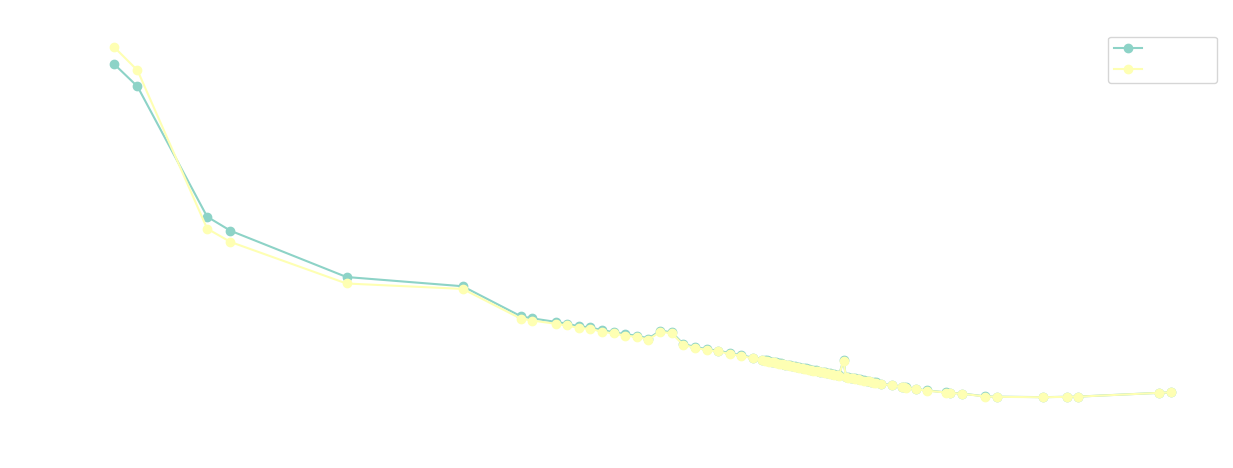

In [16]:
_, ax = plt.subplots(figsize=(15, 5))

print("Mean squared error: {:.5f}".format(np.mean((df["iv"] - df["yahoo_iv"])**2)))

ax.plot(df["strike"], df["yahoo_iv"], "o-", label="Yahoo IV")
ax.plot(df["strike"], df["iv"], "o-", label="Ours IV")
ax.legend()
ax.set_xlabel("Strike, $")
ax.set_ylabel("IV, annualized")
ax.set_title("Implied Volatilities")
plt.show()

### Let's be rational

In [18]:
import py_vollib.black.implied_volatility as iv

/home/vsevolod/.local/lib/python3.11/site-packages/py_lets_be_rational/numba_helper.py:10: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  return jit(*jit_args, **jit_kwargs)(fun)


In [19]:
option = CallStockOption(strike_price=100.0, expiration_time=1.0)
ms = MarketState(stock_price=100.0, interest_rate=0.1)
params = BSParams(volatility=0.167)

In [20]:
call_price = price(option, ms, params)
call_price

array(12.19590432)

In [21]:
%%timeit
fit_params(option, ms, call_price)

3.16 ms ± 525 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [22]:
%%timeit

iv.implied_volatility(
    call_price,
    np.exp(ms.interest_rate * (option.expiration_time - ms.time)) * ms.stock_price,
    option.strike_price,
    ms.interest_rate,
    option.expiration_time - ms.time,
    "c",
)

The slowest run took 5.34 times longer than the fastest. This could mean that an intermediate result is being cached.
27.9 µs ± 19.2 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


## Simulating 

In [24]:
def make_bsm_market_simulator(
    ms: MarketState,
    params: BSParams,
    time_stop: float,
    n_steps: int = 200,
):
    
    def simulate(n_paths: int, seed: int = 0xB0BA_C_3AB0DA):
        dt = (time_stop - ms.time) / n_steps
        random = np.random.default_rng(seed)
        norm = random.normal(size=(n_paths, n_steps))
        d_log_s = (
            (ms.interest_rate - params.volatility ** 2 / 2) * dt
            + params.volatility * norm * np.sqrt(dt)
        )
        d_log_s = np.insert(d_log_s, 0, np.zeros(n_paths), axis=1)
        return ms.stock_price * np.exp(np.cumsum(d_log_s, axis=-1))
    
    return simulate

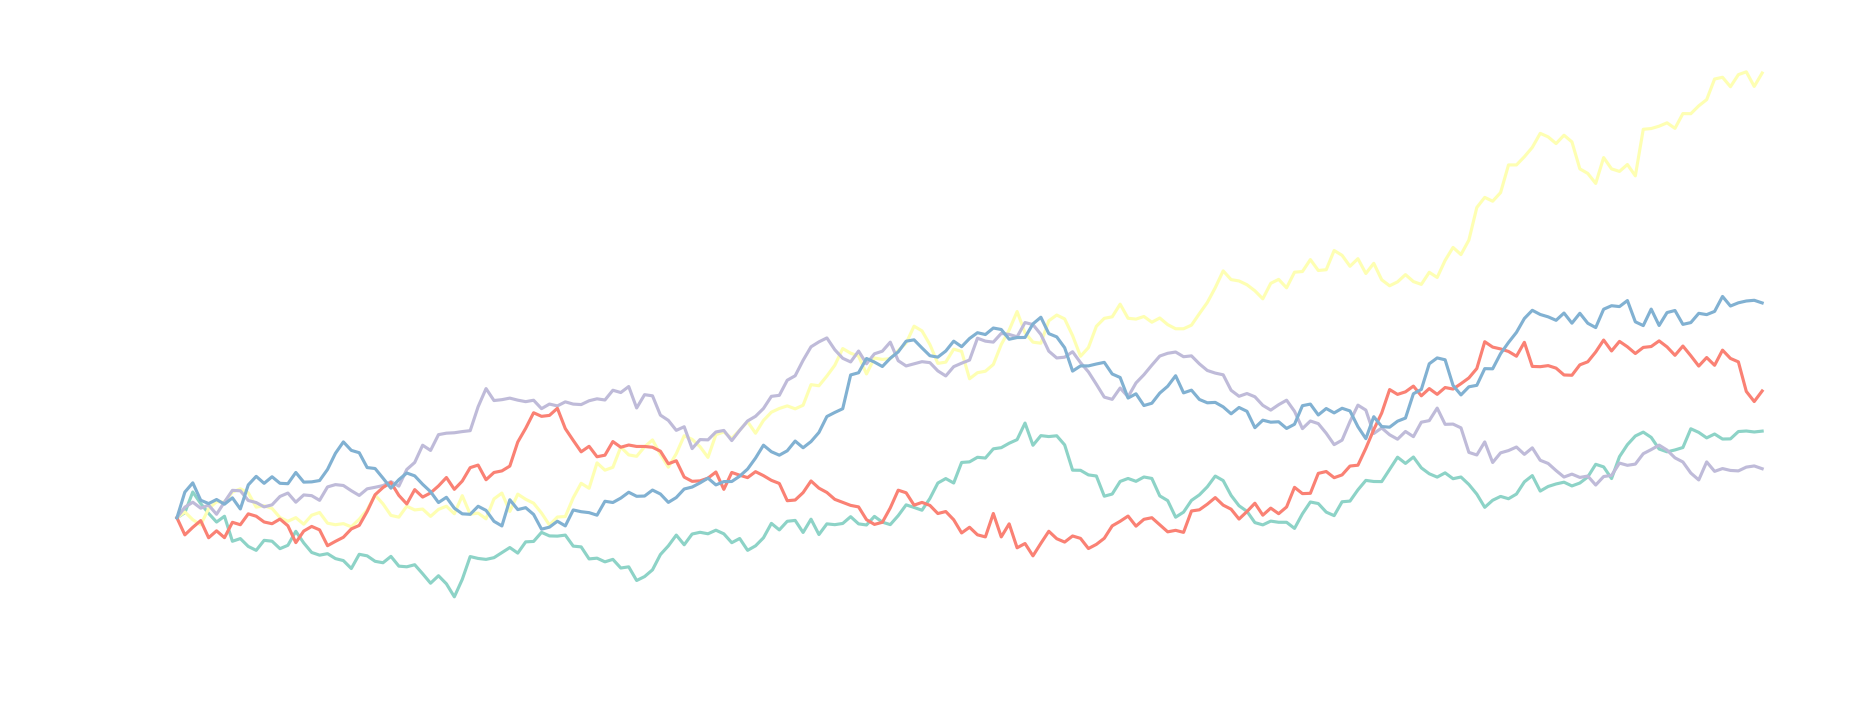

In [25]:
N = 5
STEPS = 200
T = 1.0

ms = MarketState(stock_price=100, interest_rate=0.1)
params = BSParams(volatility=0.167)
sim_fn = make_bsm_market_simulator(ms, params, T, STEPS)
paths = sim_fn(N)
t = np.linspace(0, T, STEPS + 1)

_, ax = plt.subplots(figsize=(15, 5), dpi=150)
ax.plot(t, paths.T)
ax.set_xlabel("Time, years")
ax.set_ylabel("Stock price")
ax.set_title("Simulated stock prices in the BSM model")
plt.show()

## Hedging

In [22]:
def calc_hedging_pnl(
    option: StockOption,
    ms: MarketState,
    params: BSParams,
    n_steps: int = 200,
    n_paths: int = 1000,
    seed: int = 0xB0BA_C_3AB0DA,
):
    sim_fn = make_bsm_market_simulator(ms, params, option.expiration_time, n_steps)
    paths = sim_fn(n_paths, seed)                                            # paths.shape == (n_paths, n_steps + 1)
    times = np.linspace(ms.time, option.expiration_time, n_steps + 1)[None]  # times.shape == (1,       n_steps + 1)
    bank_acc = 1.0 * np.exp(ms.interest_rate * (times - times[:, 0]))
    df = 1.0 / bank_acc
    
    inter_ms = MarketState(
        stock_price=paths,
        interest_rate=ms.interest_rate,
        time=times,
    )
        
    opt_p = price(option, inter_ms, params)
    stock_pos = delta(option, inter_ms, params)
    bank_acc_pos = df * (opt_p - stock_pos * paths)
    hedging_pnl = (
        stock_pos[:, :-1] * np.diff(paths, axis=-1)
        + bank_acc_pos[:, :-1] * np.diff(bank_acc, axis=-1)
    )
    payoff = -option.payoff(paths[:, [-1]])
    return np.append(hedging_pnl, payoff, axis=-1)

In [23]:
option = CallStockOption(strike_price=100.0, expiration_time=1.0)
ms = MarketState(stock_price=100.0, interest_rate=0.1)
params = BSParams(volatility=0.167)

In [24]:
p = price(option, ms, params)
p

array(12.19590432)

In [27]:
pl = -calc_hedging_pnl(
    option,
    ms,
    params,
    n_paths=1000,
    n_steps=200,
    seed=1,
).sum(-1)

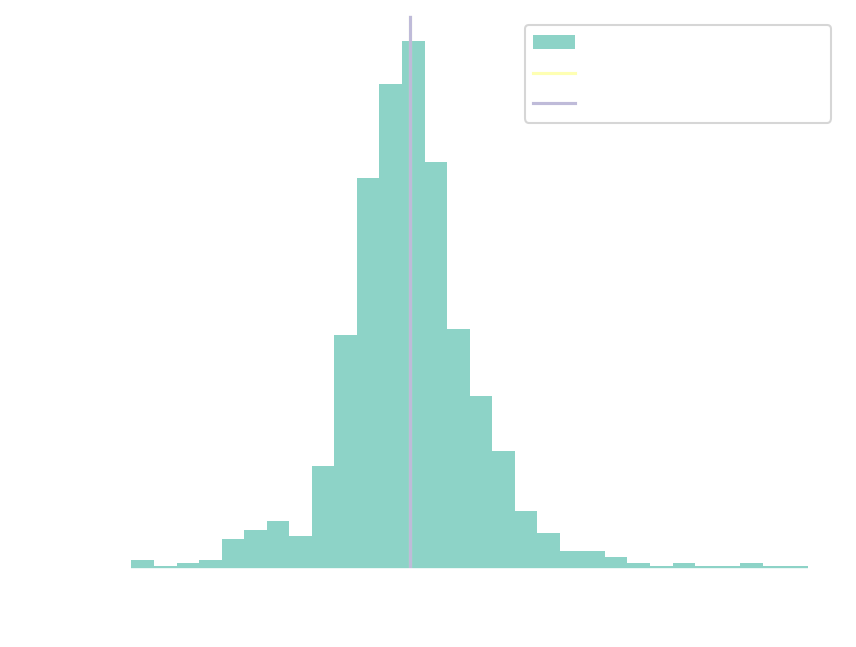

In [28]:
_, ax = plt.subplots(dpi=150)
ax.hist(pl, bins=30, label="P&L histogram")
ax.axvline(p, c="C1", label="Option price")
ax.axvline(pl.mean(), c="C2", label="Mean replication price")
ax.set_xlabel("Replication in the BSM model")
ax.set_ylabel("Count")
ax.legend()
plt.show()